In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as st
import os

In [3]:
VFILE = "../data/contest-example.mp4"

In [4]:
# get the video 
def get_frames(filename):
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            yield frame
        else:
            break
    video.release()
    yield None

In [5]:
for f in get_frames(VFILE):
    if f is None: 
        break
    cv2.imshow('frame', f)
    if cv2.waitKey(10) == 27:
        break
cv2.destroyAllWindows()

In [6]:
# get specific frame 
def get_frame(filename, index):
    counter = 0
    video = cv2.VideoCapture(filename)
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            if counter == index:
                return frame
            counter += 1
        else: 
            break
    video.release()
    return None

In [7]:
frame = get_frame(VFILE, 200)
print('shape', frame.shape)
print('pixel at (0,0)', frame[0,0,:])

shape (1080, 1920, 3)
pixel at (0,0) [36 31 23]


pixel at (0,0) [36 31 23]


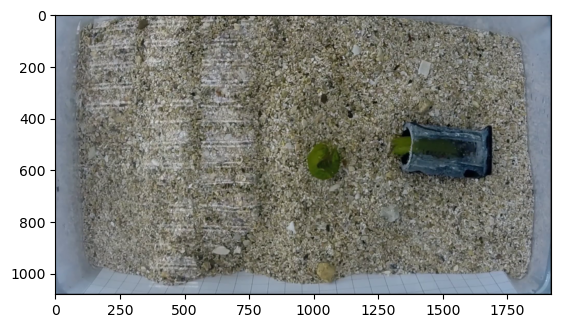

In [8]:
fix_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print('pixel at (0,0)', frame[0,0,:])
plt.imshow(fix_frame)

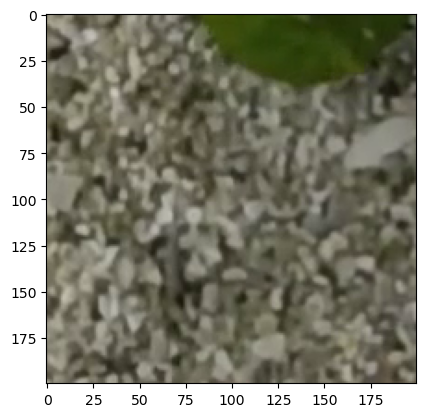

In [9]:
plt.imshow(fix_frame[600:800, 900:1100])

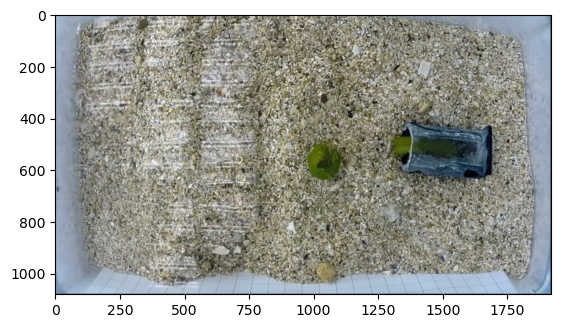

In [10]:
darker = 1.2*fix_frame
darker = darker.astype(np.uint8)
plt.imshow(darker)

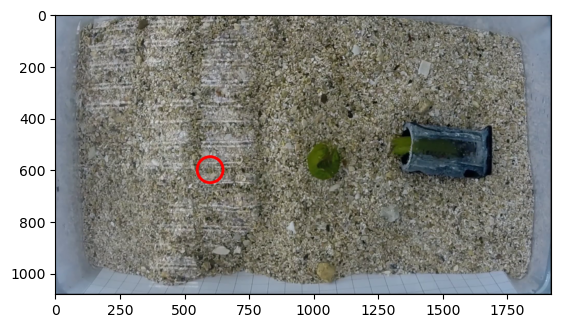

In [11]:
# draw a circle
frame = get_frame(VFILE, 200)
cv2.circle(frame, 
          center = (600,600),
          radius = 50, 
          color = (0,0,255),
          thickness = 10)
fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(fixed_frame)

In [108]:
# define a mouse move function
# everytime the mouse moved, we can determine:

# 1. the position of the mouse [x,y] 
# where x is the number of pixels counted horizontally from the left
# and y is the number of pixels counted vertically from the top

# 2. the RGB color of that position (r, g, b)

def mouseInfo(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN: # left clicked
        cv2.circle(frame, # draw a circle around the position of the click
                   (x,y), 
                   5, 
                   (255,0,0), 
                   2)
        cv2.imshow("shrimp", frame)
    if event == cv2.EVENT_MOUSEMOVE: # if mouse moved
        colorsB = frame[y,x,0] # assign the rgb value in the mouse position to variables
        colorsG = frame[y,x,1]
        colorsR = frame[y,x,2]
        puttextframe = frame.copy() # copy a new frame from the original frame to put text and shape
        # if you don't do that, all the texts will stack on the same frame
        cv2.rectangle(puttextframe, # here I put a rectangle to amplify the selected color
                      (100, 150), # this is the top-left corner of the rectangle
                      (200, 250), # the down-right corner
                      (int(colorsB), int(colorsG), int(colorsR)), # the selected color in (BGR)
                      -1) # set thickness to -1 will fill the entire rectangle
        cv2.putText(puttextframe, text='('+str(colorsR)+','+str(colorsG)+','+str(colorsB) +")"+ " [" + str(x)+','+str(y)+"]",
                    # here I put text to the frame
                    org = (100,130), # this is the start point of the text
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, # choose what font to use
                    fontScale = 0.5, # choose font size
                    color = (0,255,0), # choose font color
                    thickness = 2) # choose font thickness
        cv2.imshow("shrimp", puttextframe)


In [110]:
# processing an entire video
# analyze frame by frame
# press any key to continue/press esc to exit
counter = 0
for frame in get_frames(VFILE):
    if frame is None:
        break
    cv2.putText(frame, text=str(counter), # this line shows which frame we are looking at
               org = (100,100),
               fontFace = cv2.FONT_HERSHEY_SIMPLEX,
               fontScale = 0.5,
               color = (0,255,0),
               thickness = 2)
    cv2.imshow('shrimp', frame) # set window name as "shrimp"
    cv2.setMouseCallback('shrimp', mouseInfo) # let Opencv listen to any event happened on window "shrimp"
    if cv2.waitKey() == 27: # wait infinite time to proceed to the next frame until we press a key
        break # exist the window if the key is "esc"(27)
    counter += 1
cv2.destroyAllWindows()

In [28]:
# finding the total frame count 
video = cv2.VideoCapture(VFILE)
count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video.release()
print('frame count', count)

frame count 245


In [59]:
x = 100
y = 100
colorsB = frame[y,x,0]
colorsG = frame[y,x,1]
colorsR = frame[y,x,2]
color = (colorsB, colorsG, colorsR)


tuple

In [34]:
# show a collage
skip_frames = count // 20 # how many frames to skip between two collage frames
frames = []
counter = 0
for f in get_frames(VFILE):
    if counter % skip_frames == 0:
        frames.append(f)
    counter += 1

In [35]:
row1 = np.concatenate(frames[0:5], axis = 1)
row2 = np.concatenate(frames[5:10], axis = 1)
row3 = np.concatenate(frames[10:15], axis = 1)

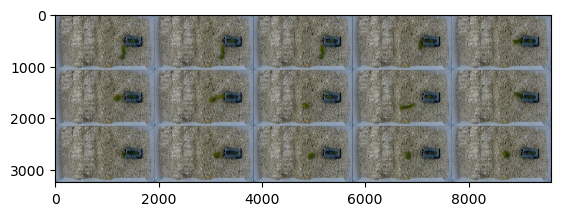

In [36]:
collage = np.concatenate((row1, row2, row3), axis = 0)
collage = cv2.cvtColor(collage, cv2.COLOR_BGR2RGB)
plt.imshow(collage)

## Video object tracking with particle filters

#### 1. We import the video and determine the width and height of the video

In [34]:
VFILE = "../data/contest-example.mp4" # specify file path
frame = get_frame(VFILE, 1) # get the first frame of the video
print(frame.shape) # check the dimension of the frame

WIDTH = frame.shape[0] # assign width and height values to variables
HEIGHT = frame.shape[1]

(1080, 1920, 3)


In [35]:
np.random.seed(0) # set random seed

#### 2. We create a particle cloud on the frames(video)

In [127]:
NUM_PARTICLES = 5000 # specify the totoal number of particle used
VEL_RANGE = 1 # set up the velocity range for the target 
assume the target is not moving more than 1 pixel per frame

# express the estimate of the target's state with a set of particles
# each particle has its own position and velocity
# particles will scatter uniformly across the frame and will have random velocity
# since we don't have any information about the target

def initialize_particles():
    particles = np.random.rand(NUM_PARTICLES, 4) # generate 4 columns of random random numbers from 0 to 1
    particles = particles * np.array((WIDTH, HEIGHT, VEL_RANGE, VEL_RANGE)) # scale up the particles
    # scale X positon with the width and Y position with the height
    # scale the other two columns with the velocity range
    particles[:,2:4] -= VEL_RANGE/2.0 # shift the velocity down so everything is centerd in zero
    # we want the velocity to be centered in 0, because we want the probability to to go any direction
    print(particles[:20, :]) # print the first 20 particles
    return particles

In [51]:
# moving the particles according to their velocity state
def apply_velocity(particles):
    particles[:,0] += particles[:,2] # increase X direction with velocity X
    particles[:,1] += particles[:,3] # increase Y direction with velocity Y
    return particles

In [91]:
# prevent particles from falling off the edge of the video frame
def enforce_edges(particles):
    for i in range(NUM_PARTICLES):
        particles[i, 0] = max(0, min(WIDTH-1, particles[i,0]))
        # prevent particles from going out of X-direction
        # use WIDTH-1 because pixels positions are zero based
        particles[i, 1] = max(0, min(HEIGHT-1, particles[i,1]))
        # prevent particles from going out of Y-direction
    return particles

In [78]:
# measure each particle's quality
TARGET_COLOUR = np.array([8, 58, 39]) # enter the target color of the object
def compute_errors(particles, frame):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        x = int(particles[i,0])
        y = int(particles[i,1])
        pixel_colour = frame[y,x,:]
        errors[i] = np.sum((TARGET_COLOUR-pixel_colour)**2)
        # compute the mean squared error of the difference
    return errors

In [93]:
# assign weights to the particles based on their quantity of match
def compute_weights(errors):
    weights = np.max(errors) - errors # weights is the inverse of errors
    weights [
        (particles[:,0] == 0) |
        (particles[:,0] == WIDTH -1) |
        (particles[:,1] == 0) |
        (particles[:,1] == HEIGHT -1)
    ] = 0.0 # give 0 weights to particles on the edges
    weights = weights ** 4 # make weights more sensitive to color
    return weights

In [85]:
# resample particles according to their weights
def resample(particles, weights):
    probabilities = weights / np.sum(weights) # normalize the weights
    index_numbers = np.random.choice(
        NUM_PARTICLES, # sample from 0 to 5000
        size = NUM_PARTICLES, # how many samples to draw
        p = probabilities) # the probabilities
    particles = particles[index_numbers,:] # resample the particles with the index
    
    x1 = np.mean(particles[:,0])
    y1 = np.mean(particles[:,1])
    
    return particles, (int(x1), int(y1))

In [145]:
# fuzz the particles
POS_SIGMA = 2.0
VEL_SIGMA = 1.0

def apply_noise(particles):
    noise = np.concatenate(
    (
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1)),
    ), axis = 1)
    particles += noise
    return particles

In [173]:
# display the video frames
def display(frame, particles, location):
    if len(particles) > 0:
        for i in range(NUM_PARTICLES): # for each particle in particles
            x = int(particles[i,0]) # get its x position
            y = int(particles[i,1]) # get its y position
            cv2.circle(frame, (x,y), 1, (0,255,0),1) # draw those particles on frome
    if len(location) > 0:
        cv2.circle(frame, location, 15, (0,0,255), 5) # draw the particular circle that track the object
    cv2.imshow('frame', frame) # show the frame
    if cv2.waitKey(30) == 27: # wait for 30 milliseconds to see if the user hit the escape button
        if cv2.waitKey(0) == 27: # if they did, pause the videl. Use waitKey(0) to wait infinite amount of time          
            return True          # until the user hit the escape button
    return False

In [ ]:
# substract the background 
# duplicate the frames when the shrimps move fast

In [178]:
# main routine
particles = initialize_particles()

for frame in get_frames(VFILE):
    if frame is None:
        break
    particles = apply_velocity(particles)
    # if we don't apply the velocity, the particles will lose the target
    # once the target is being blocked. Namely, the particles should move along with the target
    particles = enforce_edges(particles)
    errors = compute_errors(particles, frame)
    weights = compute_weights(errors)
    particles, location = resample(particles, weights)
    particles = apply_noise(particles)
    terminate = display(frame, particles, location)
    if terminate:
        break

cv2.destroyAllWindows()

[[ 2.99832146e+02  4.01219408e+02 -9.68808586e-02  1.30643605e-01]
 [ 1.22490475e+03  8.80681045e+02 -4.36853807e-01 -3.63493656e-01]
 [ 1.10594120e+03  2.11322095e+02 -4.52536713e-01 -5.32776820e-03]
 [ 8.83536426e+02  2.10512402e+02  2.42042508e-01  4.13744961e-01]
 [ 5.18191503e+02  4.78732172e+02  1.34473929e-01 -3.90489507e-01]
 [ 1.85398726e+03  9.23712805e+02  3.09299362e-01  5.54746436e-03]
 [ 8.54743190e+02  5.51529679e+02 -4.06051920e-01  3.23613440e-01]
 [ 1.53308777e+03  9.20283252e+02 -1.71908971e-01  1.93094779e-01]
 [ 1.62226231e+03  2.87997643e+02  9.29010757e-02 -3.52951504e-01]
 [ 8.57289278e+02  8.77632925e+02  2.10334932e-01  3.60495452e-01]
 [ 1.77076146e+03  4.11977650e+02  1.32917218e-02  3.69555168e-01]
 [ 1.26961238e+03  6.09937288e+02 -1.78233738e-01 -1.69362501e-01]
 [ 7.94481325e+02  6.91798481e+02  4.35205439e-01 -1.45790225e-01]
 [ 1.67384380e+03  1.06157535e+03 -3.10248956e-01  3.84478483e-01]
 [ 1.11807941e+03  7.51552052e+02  1.54866732e-01 -2.14053624e

## Recognizing Shapes in Objects 

In [154]:
f = "orange.jpg"

In [156]:
# define a function for viewing images
def view_image(i):
    cv2.imshow("view", i)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [157]:
i = cv2.imread(f)
view_image(i)

In [158]:
# inspect the gray-scale
i_gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) # convert the image to gray
print(i_gray.shape)
print(i_gray[0,0]) # brightness, 0 for black and 255 for white
view_image(i_gray)

(1160, 1300)
254


In [165]:
# X-gradiant 

# construct a new image with the same size 
# and set the brightness of each pixel to be the rate of change of the brightness 
# in the original image

# and we take the derivative of the image

sobelx = cv2.Sobel(i_gray, cv2.CV_64F, 1, 0) # take the gradient in the rightward direction
abs_sobelx = np.absolute(sobelx) # since we are only interested in the maginitude of the change
view_image(abs_sobelx / np.max(abs_sobelx))

# the brightness spots on this image represents the spots in the original image
# that the brightness changes the most

In [167]:
# Y-gradiant

# compute the Y-gradient too
sobely = cv2.Sobel(i_gray, cv2.CV_64F, 0, 1) # taking the gradient in the downward direction
abs_sobely = np.absolute(sobely)
view_image(abs_sobely/ np.max(abs_sobely)) # openCV can handle floating data but in the range of 0 to 1 so we have to normalize the data

In [179]:
# calculate the magnitude of gradient vector
# combine the two gradient
magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
view_image(magnitude / np.max(magnitude))

In [183]:
# canny edge detection
edges = cv2.Canny(i_gray, 220, 250) # pixel with brightness more than 150 will definitely
# be kept as H pixel. The pixel which is lower than 50 will defintely not be kept as H pixel.

# between these two thresholds, we check the pixel connecting to an existing edge to see if it's an edge pixel
view_image(edges)

In [210]:
# blur the image first
i_blurred = cv2.GaussianBlur(
    i_gray,
    ksize = (21,21),
    sigmaX = 0,) # adjust automatical
view_image(i_blurred)

In [213]:
# Hough transform for circles
circles = cv2.HoughCircles(
    i_blurred,
    method = cv2.HOUGH_GRADIENT,
    dp = 2,
    minDist = 35,
    param1 = 150,
    param2 = 40,
    minRadius = 15,
    maxRadius = 25)

i_circles = i.copy()
for x,y,r in circles[0]:
    cv2.circle(
        i_circles,
        (int(x),int(y)),
        int(r),
        (0,0,255),
        thickness = 3)
view_image(i_circles)

## Video Segmentation

In [131]:
# get the frame
frame = get_frame(VFILE,30)
print(type(frame))
print(frame.shape)
print(frame[35,10])

<class 'numpy.ndarray'>
(1080, 1920, 3)
[173 154 141]


(1160, 1300, 3)
[254 254 254]


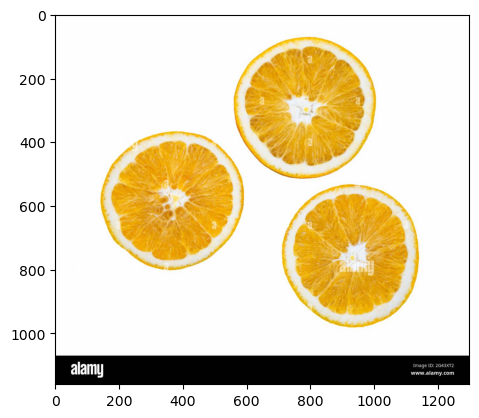

In [136]:
frame = cv2.imread("orange.jpg")
fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print(frame.shape)
print(frame[35,10])
plt.imshow(fixed_frame)

C:\Users\ircguest\AppData\Local\Temp\ipykernel_4772\565979107.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


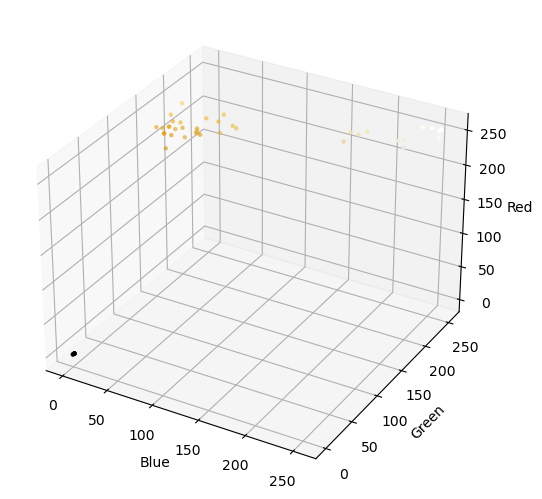

In [139]:
# flatten the image, and display in a 3-D color space

# we don't care about where the pixels are located in the picture
# so we flattened the arrays to just color tuples. 

flat = np.reshape(frame, (-1, 3))

# sample randomly some color points so it won't be too many
idx = np.random.choice(flat.shape[0], 100)
sampled_flat = flat[idx]

# create a 3-D color space

# adjust color data first
colors = sampled_flat[:,[2,1,0]] / 255.0 # convert BGR to RGB, and also normalize the values for matplotlib

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(
    sampled_flat[:,0],
    sampled_flat[:,1],
    sampled_flat[:,2],
    c = colors,
    marker = ".")

ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")

plt.show()
plt.clf() # clear the current figure
plt.close()

In [140]:
# K-means
K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 1.0)
# criteria for stopping, 1 pixel minimum accuracy, maximum iterations 250,
ssd, bestLabels, centers = cv2.kmeans(
    data = flat.astype(np.float32), # data should be in float32
    K = K, # specify the K
    bestLabels = None, # could use own labels
    criteria = criteria, # specify criteria
    attempts = 10, # make multiple attempts use different random seeds
    flags = cv2.KMEANS_RANDOM_CENTERS) # how to initialize with random centers

# ssd is the sum of square distances to measure how good the cluster is
# bestLables return the label of each pixel
# centers return the positons of centers

C:\Users\ircguest\AppData\Local\Temp\ipykernel_4772\521688444.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


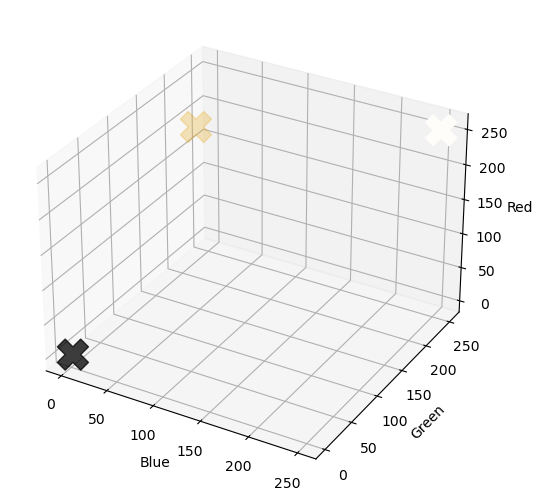

In [141]:
# plot cluster centers in RGB space
# adjust color data first
colors = centers[:,[2,1,0]] / 255 # convert BGR to RGB, and also normalize the values for matplotlib

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(
    centers[:,0],
    centers[:,1],
    centers[:,2],
    c = colors,
    marker = "X",
    s = 500)

ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")

plt.show()
plt.clf() # clear the current figure
plt.close()

In [142]:
# plot segmented image
centers = centers.astype(np.uint8)
print(centers)
print(bestLabels)

[[  1   1   1]
 [250 252 253]
 [ 34 172 230]]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [143]:
segmented_flat = centers[bestLabels]
segmented_image = segmented_flat.reshape(frame.shape)

cv2.imshow("frame", segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

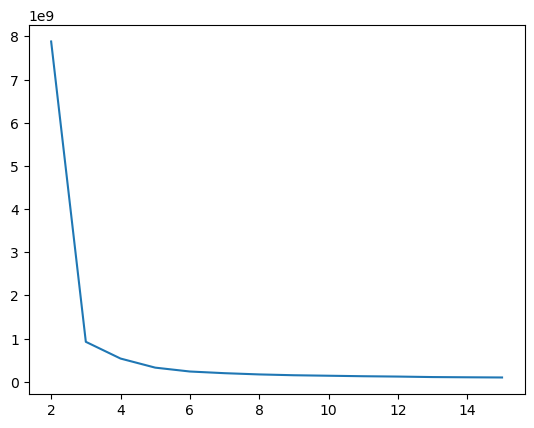

In [144]:
# determine the best K
Ks = []
distances = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 250, 1.0)

for K in range(2,16):
    ssd, bestLabels, centers = cv2.kmeans(
        data = flat.astype(np.float32),
        K = K,
        bestLabels = None,
        criteria = criteria,
        attempts = 10,
        flags = cv2.KMEANS_RANDOM_CENTERS)
    Ks.append(K)
    distances.append(ssd)
plt.plot(Ks, distances)
plt.show()